# Part 14

## # Dataset

In [1]:
import pandas as pd
import numpy as np

In [135]:
df_train = pd.read_csv('../datasets/petr4_treinamento.csv')
df_train.shape, df_train.columns

((1245, 7),
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [136]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [137]:
def _isnull(df):
    for c in df.columns:
        cnt = df[pd.isnull(df[c])].shape[0]
        if cnt != 0:
            print(f'# {c}: {cnt} rows')

In [138]:
_isnull(df_train)

# Open: 3 rows
# High: 3 rows
# Low: 3 rows
# Close: 3 rows
# Adj Close: 3 rows
# Volume: 3 rows


In [139]:
df_train.dropna(axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)
df_train.shape

(1242, 7)

In [140]:
df_train.shape

(1242, 7)

DAYS BEFORE = 90

In [141]:
def daysbefore(df, days_before, col):
    feature = []
    target = []
    for i in range(days_before, df.shape[0]):
        slice_start = i - days_before
        slice_stop = i
        feature.append(df[col].iloc[slice_start:slice_stop].values)
        target.append(df[col].iloc[i])
    return np.array(feature), np.array(target)

In [142]:
x, y = daysbefore(df_train, 90, 'Open')

In [143]:
df_open_train = pd.DataFrame(data=x)
df_open_train['target'] = y
df_open_train.shape

(1152, 91)

In [144]:
df_open_train.tail()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,target
1147,13.64,13.70,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,...,15.36,15.65,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75
1148,13.70,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,...,15.65,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75
1149,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,...,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99
1150,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,14.65,...,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99,16.10
1151,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,14.65,15.02,...,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99,16.10,16.10


In [145]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape, y.shape

((1152, 90, 1), (1152,))

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

f'{xtrain.shape}, {ytrain.shape}, {xtest.shape}, {ytest.shape}'

'(864, 90, 1), (864,), (288, 90, 1), (288,)'

## # Model

In [28]:
from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dropout, Dense, LSTM, RNN

In [263]:
def model():
    clear_session()

    model = Sequential()

    model.add(LSTM(units=100, return_sequences=True,
                   input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(Dropout(rate=0.5))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    
    model.add(LSTM(units=50))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics='mae')
    
    print(model.summary())
    
    return model

In [264]:
clf = model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 100)           42800     
_________________________________________________________________
dropout (Dropout)            (None, 90, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [265]:
clf.fit(x=xtrain, y=ytrain, validation_data=(xtest, ytest), epochs=200)

Epoch 1/200
28/28 [==============================] - 3s 111ms/step - loss: 91.7285 - mae: 8.3910 - val_loss: 48.2194 - val_mae: 5.8818
Epoch 2/200
23/28 [=======================>......] - ETA: 0s - loss: 42.2617 - mae: 5.4971

KeyboardInterrupt: 

## # Evaluation

In [220]:
pred = clf.predict(xtest)

In [221]:
ytest.shape, pred.shape

((288,), (288, 1))

In [209]:
ytest.mean() - pred.mean()

0.23415341501193687

In [210]:
ytest.std() - pred.std()

-0.02007471726045118

### ## Test data

In [196]:
df_test = pd.read_csv('../datasets/petr4_teste.csv')
df_test.shape, df_test.columns

((22, 7),
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [197]:
df_test.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000
21,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600


In [198]:
df_complete = pd.concat(objs=[df_train, df_test], axis=0)
df_complete.reset_index(inplace=True, drop=True)
df_complete.shape

(1264, 7)

In [199]:
df_complete.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1259,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
1260,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
1261,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
1262,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0
1263,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600.0


In [235]:
x, y = daysbefore(df_complete, 90, 'Open')

In [236]:
x.shape, y.shape

((1174, 90), (1174,))

In [237]:
df_open_test = pd.DataFrame(data=x)
df_open_test['target'] = y
df_open_test.shape

(1174, 91)

In [239]:
df_open_test.tail()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,target
1169,15.25,15.85,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,...,17.040001,17.320000,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000
1170,15.85,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,...,17.320000,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001
1171,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,...,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000
1172,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,15.66,...,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000,19.770000
1173,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,15.66,15.61,...,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000,19.770000,19.740000


In [240]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape, y.shape

((1174, 90, 1), (1174,))

In [241]:
pred = clf.predict(x)

In [242]:
pred.shape, y.shape

((1174, 1), (1174,))

In [243]:
y.mean() - pred.mean()

0.25753281960264296

In [244]:
y.std() - pred.std()

-0.018483486639921054

In [245]:
import matplotlib.pyplot as plt

%matplotlib notebook

<IPython.core.display.Javascript object>


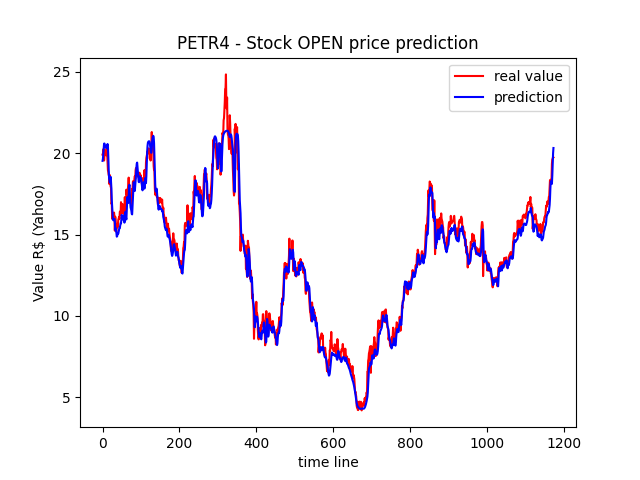

In [247]:
plt.plot(y, color='red', label='real value')
plt.plot(pred, color='blue', label='prediction')
plt.title('PETR4 - Stock OPEN price prediction')
plt.xlabel('time line')
plt.ylabel('Value R$ (Yahoo)')
plt.legend()
plt.show()

## ## Multiple inputs

In [268]:
df_train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [277]:
x, _ = daysbefore(df_train, 90, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
y = df_train['Open'][90:]
x.shape, y.shape

((1152, 90, 6), (1152,))

In [278]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

f'{xtrain.shape}, {ytrain.shape}, {xtest.shape}, {ytest.shape}'

'(864, 90, 6), (864,), (288, 90, 6), (288,)'

In [279]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [280]:
clf = model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 100)           42800     
_________________________________________________________________
dropout (Dropout)            (None, 90, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [284]:
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(monitor='loss', filepath='sess_14-weights.h5.',
                      save_best_only=True, verbose=1)

In [285]:
clf.fit(x=xtrain, y=ytrain, validation_data=(xtest, ytest), epochs=200,
        callbacks=[es, rlr, mcp])

Epoch 1/200
27/27 [==============================] - ETA: 0s - loss: 75.1533 - mae: 7.4652WARNING:tensorflow:From /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: sess_14-weights.h5./assets
27/27 [==============================] - 31s 1s/step - loss: 75.1533 - mae: 7.4652 - val_loss: 37.1278 - val_mae: 5.0282
Epoch 2/200
27/27 [==============================] - 27s 1s/step - loss: 30.4603 - mae: 4.5822 - val_loss: 24.5321 - val_mae: 4.2050
Epoch 3/200
27/27 [==============================] - 27s 1s/step - loss: 22.2251 - mae: 3.9189 - val_loss: 19.4

KeyboardInterrupt: 

### ## Evaluation

In [ ]:
pred = clf.predict(xtest)

In [ ]:
ytest.shape, pred.shape

In [ ]:
ytest.mean() - pred.mean()

In [ ]:
ytest.std() - pred.std()

### ## Test data

In [ ]:
x, y = daysbefore(df_complete, 90, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

In [ ]:
x, _ = daysbefore(df_complete, 90, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
y = df_complete['Open'][90:]
x.shape, y.shape